# Time-Series Modeling Lesson with Stock Data
### Kwame V. Taylor

In [53]:
# imports
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt 

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

# default viz settings
plt.rc('figure', figsize=(14, 11))
plt.rc('font', size=15)
plt.rc('lines', linewidth=2, c='m')
plt.style.use('seaborn-whitegrid')

### Acquire and prepare the stock data.

In [26]:
# get stock data
from vega_datasets import data
stocks = data.stocks()
# to transform such that each symbol is it's own column and each row is one month
stocks.pivot_table('price', 'date', 'symbol')

symbol,AAPL,AMZN,GOOG,IBM,MSFT
date,,,,,
2000-01-01,25.94,64.56,NaN,100.52,39.81
2000-02-01,28.66,68.87,NaN,92.11,36.35
2000-03-01,33.95,67.00,NaN,106.11,43.22
2000-04-01,31.01,55.19,NaN,99.95,28.37
2000-05-01,21.00,48.31,NaN,96.31,25.45
...,...,...,...,...,...
2009-11-01,199.91,135.91,583.00,125.79,29.27
2009-12-01,210.73,134.52,619.98,130.32,30.34
2010-01-01,192.06,125.41,529.94,121.85,28.05


I just want to focus on IBM.

In [27]:
IBM = pd.DataFrame(stocks[stocks['symbol'] == 'IBM'])
IBM = stocks.pivot_table('price', 'date')
IBM

,price
date,
2000-01-01,57.7075
2000-02-01,56.4975
2000-03-01,62.5700
2000-04-01,53.6300
2000-05-01,47.7675
...,...
2009-11-01,214.7760
2009-12-01,225.1780
2010-01-01,199.4620


In [28]:
IBM.isna().sum()

price    0
dtype: int64

In [41]:
IBM.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 123 entries, 2000-01-01 to 2010-03-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   123 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


I'll remove leap days later if I have time.

### Split the data

In [31]:
train_size = int(len(IBM) * .5)
train_size

61

In [32]:
validate_size = int(len(IBM) * .3)
validate_size

36

In [33]:
test_size = int(len(IBM) - train_size - validate_size)
test_size

26

In [34]:
validate_end_index = train_size + validate_size
validate_end_index

97

In [36]:
# use the above values to split the df
train = IBM[: train_size]
validate = IBM[train_size:validate_end_index]
test = IBM[validate_end_index:]

**Verify the splits.**

Does the length of each df equate to the length of the original df?

In [39]:
print(len(train) + len(validate) + len(test) == len(IBM))

True


Does the first row of original df equate to the first row of train?

In [40]:
print(IBM.head(1) == train.head(1))

            price
date             
2000-01-01   True


Is the last row of train the month before the first row of validate? And the same for validate to test?

In [42]:
pd.concat([train.tail(1), validate.head(1)])

,price
date,
2005-01-01,77.558
2005-02-01,75.392


In [43]:
pd.concat([validate.tail(1), test.head(1)])

,price
date,
2008-01-01,182.248
2008-02-01,159.276


Is the last row of test the same as the last row of our original dataframe?

In [45]:
pd.concat([test.tail(1), IBM.tail(1)])

,price
date,
2010-03-01,213.276
2010-03-01,213.276


Let's plot our data first, viewing where the data is split into train and test.

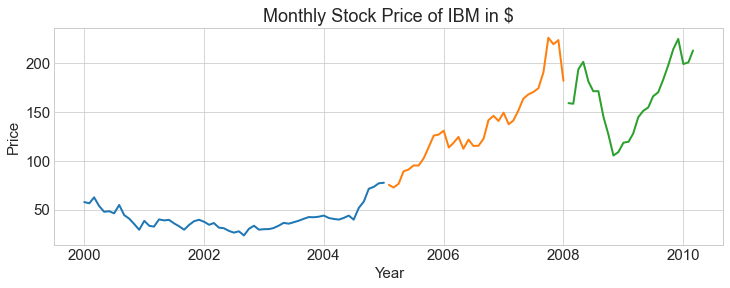

In [54]:
plt.figure(figsize=(12,4))
plt.plot(train['price'])
plt.plot(validate['price'])
plt.plot(test['price'])
plt.ylabel('Price')
plt.xlabel('Year')
plt.title('Monthly Stock Price of IBM in $')
plt.show()